# Predict Storms 

In [34]:
%matplotlib inline
from os.path import join, expanduser
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import percentileofscore
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os
from sklearn.preprocessing import StandardScaler
from keras.models import Model, save_model, load_model
from keras.layers import Dense, Activation, Conv2D, Input, AveragePooling2D, MaxPooling2D, Flatten, LeakyReLU, Dropout
from keras.layers import SpatialDropout2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import keras.backend as K
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error, roc_auc_score

In [6]:
path = "./data/track_data_ncar_ams_3km_csv_small/"
files = sorted(glob.glob(path+"/*.csv"))
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

In [7]:
df.columns

Index(['Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
       'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC', 'Duration',
       'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
       'Storm_Motion_U', 'Storm_Motion_V', 'REFL_COM_mean', 'REFL_COM_max',
       'REFL_COM_min', 'REFL_COM_std', 'REFL_COM_percentile_10',
       'REFL_COM_percentile_25', 'REFL_COM_percentile_50',
       'REFL_COM_percentile_75', 'REFL_COM_percentile_90', 'U10_mean',
       'U10_max', 'U10_min', 'U10_std', 'U10_percentile_10',
       'U10_percentile_25', 'U10_percentile_50', 'U10_percentile_75',
       'U10_percentile_90', 'V10_mean', 'V10_max', 'V10_min', 'V10_std',
       'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50',
       'V10_percentile_75', 'V10_percentile_90', 'T2_mean', 'T2_max', 'T2_min',
       'T2_std', 'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50',
       'T2_percentile_75', 'T2_percentile_90', 'RVORT1_MAX-future_mean',
       'RVOR

In [8]:
df.head()

,Step_ID,Track_ID,Ensemble_Name,Ensemble_Member,Run_Date,Valid_Date,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,...,eccentricity,major_axis_length,minor_axis_length,orientation,Matched,Max_Hail_Size,Num_Matches,Shape,Location,Scale
0,d01_REFL_COM_20101024-0000_12_12_000_00,d01_REFL_COM_20101024-0000_12_12_000,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 12:00:00,12,12,1,-93.43888,...,0.78628,4.27766,2.64302,-0.10555,0,0,0,0,0,0
1,d01_REFL_COM_20101024-0000_12_12_001_00,d01_REFL_COM_20101024-0000_12_12_001,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 12:00:00,12,12,1,-93.06068,...,0.47108,7.07588,6.24158,-1.33266,0,0,0,0,0,0
2,d01_REFL_COM_20101024-0000_12_15_002_00,d01_REFL_COM_20101024-0000_12_15_002,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 12:00:00,12,12,1,-93.65033,...,0.87636,9.90123,4.76900,-0.10405,0,0,0,0,0,0
3,d01_REFL_COM_20101024-0000_12_15_002_01,d01_REFL_COM_20101024-0000_12_15_002,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 13:00:00,13,13,2,-93.28486,...,0.97896,16.76704,3.42129,-0.71430,0,0,0,0,0,0
4,d01_REFL_COM_20101024-0000_12_15_002_02,d01_REFL_COM_20101024-0000_12_15_002,NCARSTORM,d01,2010-10-24 00:00:00,2010-10-24 14:00:00,14,14,3,-92.73067,...,0.94226,9.77854,3.27479,-0.91437,0,0,0,0,0,0


Text(0, 0.5, 'Temperature')

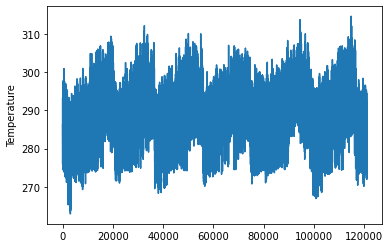

In [9]:
df['T2_mean'].plot()
plt.ylabel("Temperature")

Text(0.5, 1.0, 'Tornadic Storm Spatial Frequency')

C:\Users\unknown\Anaconda3\envs\polito\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Users\unknown\Anaconda3\envs\polito\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


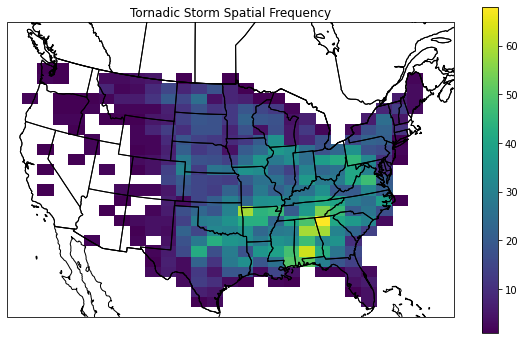

In [10]:
proj = ccrs.LambertConformal()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=proj)
countries = cfeature.NaturalEarthFeature("cultural", "admin_0_countries", "50m", facecolor="None", edgecolor="k")
states = cfeature.NaturalEarthFeature("cultural", "admin_1_states_provinces", "50m", facecolor="None", edgecolor="k")
ax.add_feature(countries)
ax.add_feature(states)
tor_idx = df["RVORT1_MAX-future_max"] > 0.005
out_points = proj.transform_points(ccrs.PlateCarree(), 
                            df.loc[tor_idx, "Centroid_Lon"].values, df.loc[tor_idx, "Centroid_Lat"].values)
out = ax.hist2d(out_points[:, 0], out_points[:, 1], bins=(np.linspace(-2.5e6, 2.5e6, 30), 
                                                          np.linspace(-1.5e6, 1.8e6, 30)), cmin=1)
ax.set_extent([-2.5e6, 2.5e6, -1.5e6, 1.8e6], crs=proj)
plt.colorbar(out[-1])
plt.title("Tornadic Storm Spatial Frequency")

In [14]:
path = "./data/track_data_ncar_ams_3km_nc_small/"

# create a list of the files and print it out
files = sorted(glob.glob(path+"/*.nc"))


In [16]:
xf = xr.open_dataset(files[0])
xf

<xarray.Dataset>
Dimensions:            (col: 32, p: 1472, row: 32)
Coordinates:
  * p                  (p) int32 0 1 2 3 4 5 6 ... 1466 1467 1468 1469 1470 1471
  * row                (row) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * col                (col) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
Data variables: (12/20)
    lon                (p, row, col) float32 ...
    lat                (p, row, col) float32 ...
    i                  (p, row, col) int32 ...
    j                  (p, row, col) int32 ...
    x                  (p, row, col) float32 ...
    y                  (p, row, col) float32 ...
    ...                 ...
    REFL_COM_curr      (p, row, col) float32 ...
    U10_curr           (p, row, col) float32 ...
    V10_curr           (p, row, col) float32 ...
    T2_curr            (p, row, col) float32 ...
    RVORT1_MAX_future  (p, row, col) float32 ...
    HAIL_MAXK1_future  (p, row, col) float32 ...
Attributes:
    Conventions:      CF-1.6
    title:            NCARSTORM Storm Patches for run 20101024-0000 member d01
    object_variable:  REFL_COM

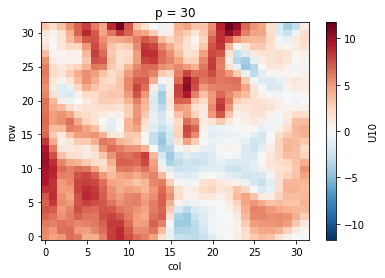

In [26]:
xf["U10_curr"].isel(p=30).plot()

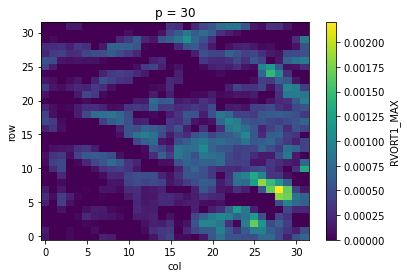

In [27]:
xf["RVORT1_MAX_future"].isel(p=30).plot()

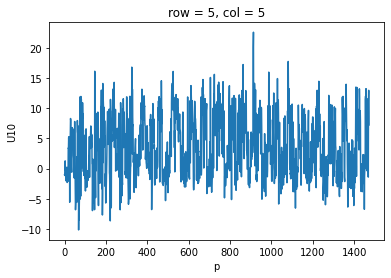

In [28]:
xf["U10_curr"].isel(col=5, row=5).plot()

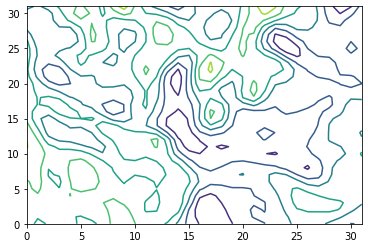

In [30]:
plt.contour(xf["U10_curr"][30,:,:])

### Ex1: 

Play with xarray plots and explore the dataset. 

## Prepare data for training 

In [51]:
features = ["REFL_COM_curr", "U10_curr", "V10_curr", "T2_curr"]
target = ["RVORT1_MAX_future"]

In [52]:
run_times = []
valid_times = []
# List of input variables

inputs = []
output = []
# Loop through each storm file and extract the relevant variables
for storm_file in files:
    # Extract run time from the filename
    run_time = pd.Timestamp(storm_file.split("/")[-1].split("_")[-4])
    # If you want to ignore certain run_dates, encapsulate the remaining lines in an if statement
    ds = xr.open_dataset(storm_file)
    # Stack the variables in the order listed within a given file
    inputs.append(np.stack([ds[v].values for v in features], axis=-1))
    output.append(np.stack([ds[v].values for v in target], axis=-1))
    # Extract the valid times
    valid_times.append(ds["time"].values)
    # Extract the run times and match each run time with each patch
    run_times.append([run_time] * inputs[-1].shape[0])
    print(run_time)
    ds.close()
# Stack the  data into single arrays instead of lists of arrays
X = np.vstack(inputs)
y = np.vstack(output)
all_run_times = np.concatenate(run_times)
all_valid_times = np.concatenate(valid_times)
# Deallocate the lists of arrays to save memory
del inputs[:], output[:], run_times[:], valid_times[:]
del inputs, output, run_times, valid_times

2010-10-24 00:00:00
2010-11-22 00:00:00
2011-02-01 00:00:00
2011-03-08 00:00:00
2011-03-26 00:00:00
2011-04-04 00:00:00
2011-04-14 00:00:00
2011-04-20 00:00:00
2011-04-25 00:00:00
2011-05-09 00:00:00
2011-05-22 00:00:00
2011-05-27 00:00:00
2011-06-05 00:00:00
2011-06-10 00:00:00
2011-06-15 00:00:00
2011-06-20 00:00:00
2011-06-25 00:00:00
2011-07-04 00:00:00
2011-07-12 00:00:00
2011-11-16 00:00:00
2012-02-18 00:00:00
2012-03-15 00:00:00
2012-03-23 00:00:00
2012-04-01 00:00:00
2012-04-09 00:00:00
2012-04-26 00:00:00
2012-05-03 00:00:00
2012-05-10 00:00:00
2012-05-29 00:00:00
2012-06-06 00:00:00
2012-06-22 00:00:00
2012-07-01 00:00:00
2012-07-06 00:00:00
2012-07-15 00:00:00
2012-12-25 00:00:00
2013-03-18 00:00:00
2013-03-31 00:00:00
2013-04-11 00:00:00
2013-04-29 00:00:00
2013-05-13 00:00:00
2013-05-19 00:00:00
2013-05-27 00:00:00
2013-06-02 00:00:00
2013-06-13 00:00:00
2013-06-19 00:00:00
2013-06-25 00:00:00
2013-07-01 00:00:00
2013-07-08 00:00:00
2013-07-15 00:00:00
2014-02-20 00:00:00


In [55]:
len(all_valid_times) == len(all_run_times)

True